# Analysis of MIMICIII ICU Data for Sepsis Cases
# What decisions, and what business/societal value will be impacted 
Our project focuses on refining ICU patient monitoring systems by developing a specialized, real-time machine learning model. This model will be designed to analyze a range of clinical indicators specifically for sepsis patients, predicting when their conditions might escalate into life-threatening situations.

The alarm system in our model will be highly targeted: it will only activate in cases of imminent, critical danger to sepsis patients, avoiding the issuance of alerts for less severe conditions. This focused approach aims to prevent the overload of false alarms, thereby reducing unnecessary stress on ICU staff and ensuring that medical attention is directed swiftly and accurately to patients in urgent need.

By ensuring that alarms are only triggered by truly critical situations, the model will enhance the effectiveness of patient monitoring in the ICU, leading to better patient outcomes, fewer medical errors, and improved overall efficiency in patient care management.

## **PART I: Dataset Structure**
## 1. Why sepsis?
Since there are many different diseases in MIMICIII and it would be more efficient if we choose only one disease to analyze.

First we analyze the number of different diseases.

                               diagnosis   num
0                                NEWBORN  7718
1                              PNEUMONIA  1619
2                                 SEPSIS  1250
3               CONGESTIVE HEART FAILURE   993
4                CORONARY ARTERY DISEASE   890
...                                  ...   ...
14983         ETOH WITHDRAWAL;CHEST PAIN     1
14984          ETOH WITHDRAWAL;CIRRHOSIS     1
14985        ETOH WITHDRAWAL;EKG CHANGES     1
14986  ETOH WITHDRAWAL;FAILURE TO THRIVE     1
14987                               None     1

[14988 rows x 2 columns]


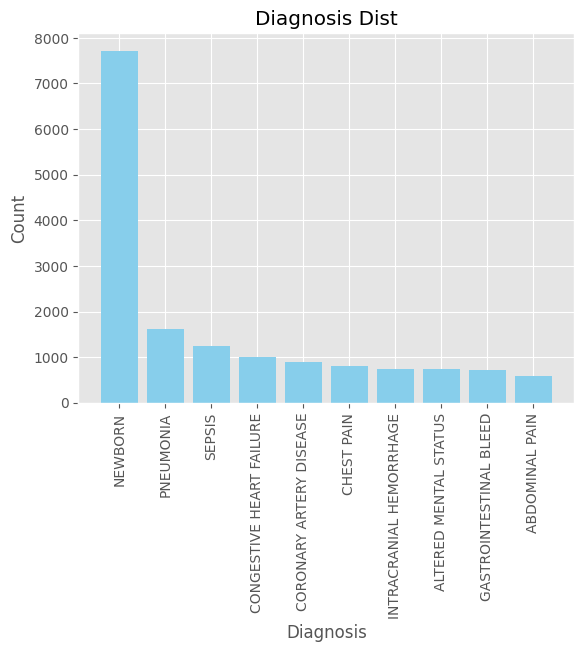

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from IPython.display import display, HTML

plt.style.use('ggplot')

sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii_generate'
password = '012500'
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
query_schema = 'set search_path to ' + schema_name + ';'

diag_only_query = '''
select distinct diagnosis, count(distinct icustay_id) as num
from mimiciii_generate.patients_all
where subject_id is not null 
group by diagnosis
order by diagnosis asc;
'''
diagnosis_num = pd.read_sql_query(diag_only_query, con)
diagnosis_num = diagnosis_num.sort_values(by='num',ascending=False).reset_index(drop=True)
print(diagnosis_num)
#diagnosis_num.to_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\all_diag.csv')

sepsis_top10 = diagnosis_num.head(10)
plt.bar(sepsis_top10['diagnosis'], sepsis_top10['num'],color='skyblue')
plt.title('Diagnosis Dist')
plt.xlabel('Diagnosis')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

It turns out that, except for newborn, sepsis has the second highest number of cases. Besides, sepsis is one of the most deadly diseases in the United States. Therefore, we choose **sepsis** as our subject.


## 2. Table Join and Feature Description

Tables used:
- `patients`
- `icustays`
- `chartevents`
- `outputevents`
- `d_items`

### Features: Personal info & Test values

### 2.1 Personal Info Features
- `subject_id`: Number for each patient
- `icustay_id`: Number for each ICU case
- `age`: Patient's age
- `gender`: Patient's gender
- `marital_status`: Marital status of the patient
- `ethnicity`: Ethnicity of the patient
- `icu_duration_hour`: Time spent in ICU
- `icu_times`: The ith time being admitted to ICU
- `icu_times_total`: Total number of times admitted to ICU
- `icu_times_sepsis`: The ith time admitted to ICU because of sepsis
- `icu_times_total_sepsis`: Total times admitted to ICU because of sepsis
- `hospital_expire_flag`: Died in hospital
- `expire_flag`: Died eventually
- `died_immediately`: Died in hospital or within 24h after leaving hospital[TARGET]

### 2.2 Test Values Features
**What tests should be considered?**

Since there are hundreds of medical tests in MIMICIII, it would be very time consuming to process all of these test values and take all of them into account. Therefore, we will select a small part of these tests to be our features.

We calculated the proportion of patients participating in each type of test. As shown in the code below, and we select the **top 20** tests. Some tests are actually the same test but with different names, we regard them together as one test.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from IPython.display import display, HTML

plt.style.use('ggplot')

sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii_generate'
password = '012500'
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
query_schema = 'set search_path to ' + schema_name + ';'

patient_sepsis_complete_query = '''
WITH   patient_sepsis as (
        select * from mimiciii_generate.patient_sepsis_complete
        )
        select * from patient_sepsis
    
'''

patient_sepsis_complete = pd.read_sql_query(patient_sepsis_complete_query, con)
case_num = patient_sepsis_complete['icustay_id'].nunique()
test_counts = patient_sepsis_complete.groupby('test_label')['icustay_id'].nunique()
test_percent = (test_counts / case_num * 100).round(2).reset_index()
test_percent.columns = ['test_label', 'test_percent']
test_percent = test_percent.sort_values(by='test_percent', ascending=False).reset_index(drop=True)
print(test_percent)

               test_label  test_percent
0        Glucose (70-105)         61.80
1     Potassium (3.5-5.3)         61.80
2        Sodium (135-148)         61.75
3              Hematocrit         61.64
4      Chloride (100-112)         61.59
...                   ...           ...
1250   Erythromycin Oint.          0.05
1251                 FIO2          0.05
1252    FIO2 Alarm [High]          0.05
1253     FIO2 Alarm [Low]          0.05
1254  KCL-10 MEQ-DIALYSIS          0.05

[1255 rows x 2 columns]


The final selected medical test lables are as shown below.

| Measurement Type   | Initial Label            | Merged Label         |
|--------------------|--------------------------|----------------------|
| **Blood Sugar**    | Glouse                   | glouse               |
|                    | Glucose (70-105)         |                      |
|                    | Fingerstick Glucose      | Fingerstick Glucose  |
| **Electrolyte**    | potassium                | potassium            |
|                    | Potassium (3.5-5.3)      |                      |
|                    | Potassium  (3.5-5.3)     |
|                    | Sodium (135-148)         | Sodium               |
|                    | Chloride (100-112)       | Chloride             |
|                    | Magnesium (1.6-2.6)      | Magnesium            |
| **Blood Component**| Hematocrit (35-51)       | Hematocrit           |
|                    | Hematocrit               |                      |
|                    | Hemoglobin               | Hemoglobin           |
|                    | RBC(3.6-6.2)             | RBC                  |
|                    | RBC                      |                      |
|                    | Platelets                | Platelets            |
|                    | WBC (4-11,000)           | WBC                  |
|                    | WBC   (4-11,000)         |                      |
|                    | WBC 4.0-11.0             |                      |
| **Kidney Function**| BUN (6-20)               | BUN                  |
|                    | BUN                      |                      |
|                    | Creatinine (0-1.3)       | Creatinine           |
| **Blood Gas**      | Carbon Dioxide           | Carbon Dioxide       |
| **Vital Sign**     | Heart Rate               | Heart Rate           |
|                    | Heart Rhythm             | Heart Rhythm         |
|                    | Respiratory Rate         | Respiratory Rate     |
|                    | Temperature (C to F)     | Temperature (C to F) |
|                    | SPO2                     | SPO2                 |


#### **Min, Max, and Avg Calculations for Each Test
Example for Glucose:
- Min: 70
- Max: 105
- Avg: Calculated from available data

#### Exception 1: For SPO2（Oxygen Saturation）, We calculated **Alarm times**: Times of the value below/beyond certain threshold. 

#### Exception 2: For Heart Rhythm, which is recorded in text, we calculated the mode and the last value of the patient.



## 3. Pre-process
### 3.1 Last Case Handling
Since the same patient will have similar test values, which might affect the model, we select the last time one patient get admitted to ICU because of sepsis if the patient get admitted to ICU for multiple times. 

### 3.2 Drop Duplicates
Since the mode of heart rhythm might not be a unique value if two or more values have the same amount. We decided to delete all of them completely. Only 10 patients (20 records) will be removed, which might not affect the data set too much. Also, only one of the duplicated records ends up died. If we are doing an outlier detection, this also does not remove too much of the positive samples.

### 3.3 Drop Nulls
Top 20 most common tests among sepsis patients.If a patient has more than 25% of tests not conducted, then remove that patient.
End up in 922 cases in total.

**Below is how we build the dataset and a sample of this dataset**

--We process the initial data on PostgreSQL (code skiped)

#### The dataset we will use in this project

In [3]:
import pandas as pd
file_path = 'F:\STUDY\python_code\Pract_DA\prepocess\patient_sepsis_all_dropdup_dropnull25.csv'
data = pd.read_csv(file_path)
data.head(10)

,Unnamed: 0,subject_id,icustay_id,age,gender,marital_status,ethnicity,icu_duration_hour,icu_times,icu_times_total,...,spo_min,spo_max,spo_avg,spo_alarms,temp_min,temp_max,temp_avg,hospital_expire_flag,expire_flag,died_immediately
0,0,21,216859,87.82,M,MARRIED,WHITE,8.3647,2,2,...,75.0,100.0,95.47,8.0,96.3,100.3,97.98,1,1,1
1,1,33,296681,82.39,M,MARRIED,UNKNOWN/NOT SPECIFIED,1.5542,1,1,...,92.0,99.0,95.46,0.0,97.4,99.4,98.43,0,0,0
2,2,38,248910,75.94,M,WIDOWED,WHITE,25.5485,1,1,...,68.0,100.0,99.02,1.0,94.3,102.0,99.34,0,0,0
3,3,62,216609,68.77,M,MARRIED,PATIENT DECLINED TO ANSWER,2.8257,1,1,...,91.0,100.0,96.60,0.0,95.7,98.8,97.40,0,0,0
4,4,94,229012,74.43,M,MARRIED,ASIAN,1.0985,1,2,...,97.0,100.0,99.26,0.0,97.9,99.8,98.99,0,1,0
5,5,157,264885,80.53,M,SINGLE,WHITE,4.1192,2,2,...,88.0,100.0,97.24,1.0,95.6,99.7,98.03,0,1,0
6,7,188,278679,51.80,M,MARRIED,WHITE,1.1900,2,8,...,96.0,100.0,98.71,0.0,95.7,97.8,97.16,0,1,0
7,8,202,228132,75.76,F,MARRIED,WHITE,1.6262,1,1,...,79.0,100.0,96.47,2.0,96.7,98.7,97.86,0,0,0
8,9,234,252814,52.59,M,WIDOWED,WHITE,5.1612,1,2,...,90.0,100.0,96.48,0.0,95.8,98.3,97.01,0,1,0
9,10,242,270389,76.98,F,WIDOWED,UNKNOWN/NOT SPECIFIED,1.7014,1,1,...,85.0,100.0,96.71,5.0,95.8,99.4,97.60,0,1,0



## 4. Comorbidity Consideration
We have calculated comorbidity and added this feature to the dataset. However, through feature selection process, we found this feature to be not very impactive to target value. The reason will be discussed in later sections.

## **PART II: Data Description and Distribution**

## How death rate relate to the distribution of the values

Follow is the distribution of all of the features. Most values follows normal distribution and shows very similar distributions given positive or negative class. This means such features are not very impactive to our target value. So it is possible to get rid of part of these features. 

However, some features shows a clear difference on the distribution of positive class and negative class. These features could be very important in identifying dead patients. We take `Hem_min` as an example. The peak of Hem_min for negative class is about 27, while the peak for positive class is about 25. In our feature selection process, it turns out that Hem_min is selected by all of the models, meaning it is a very important feature.

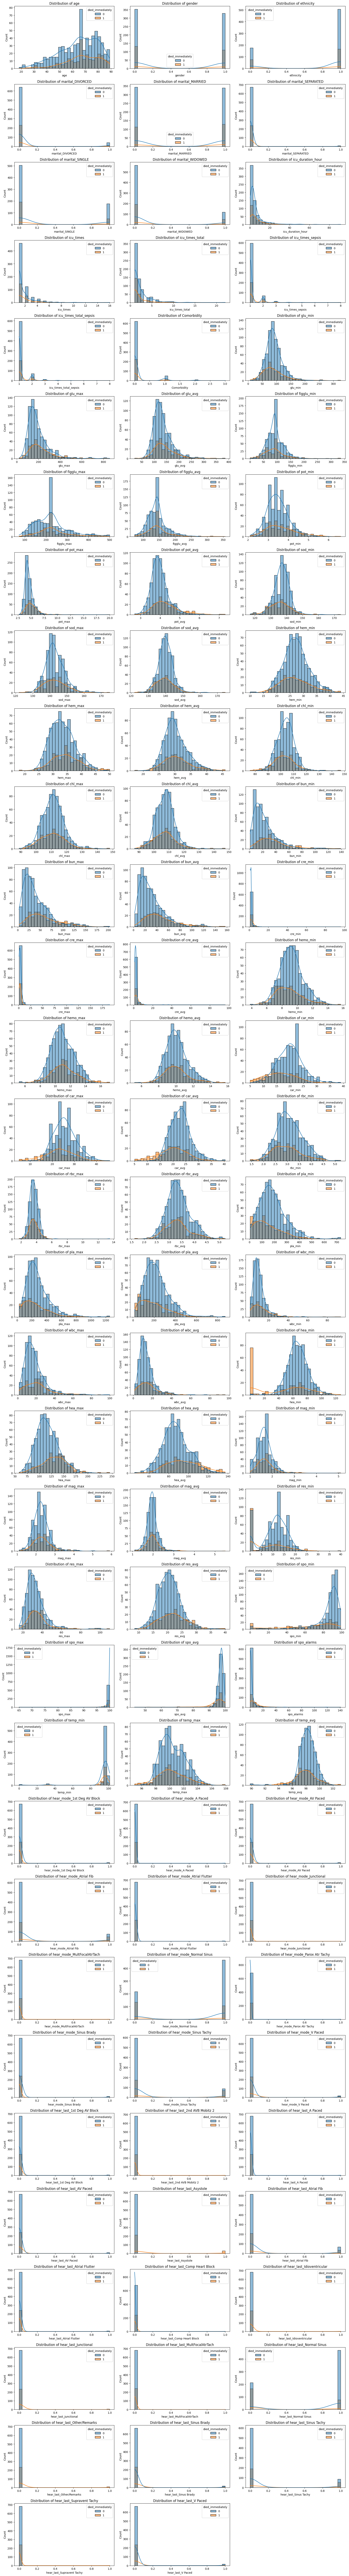

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


path = r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv'
data = pd.read_csv(path)


test_columns = list(data.columns[2:-3])
rows = (len(test_columns) + 2) // 3

fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 4))
axes = axes.flatten()

for i, col in enumerate(test_columns):
    sns.histplot(data=data, x=col, hue='died_immediately', ax=axes[i], bins=30, kde=True, alpha=0.5)
    axes[i].set_title(f'Distribution of {col}')
    if col == 'hear_mode' or col == 'hear_last':
        axes[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Follows is the correlation map for all the features and target value. This figure shows that most features do not have linear relationship with other features. Some 'red squares' could be observed on the main diagonal of the map. This is because we use min/max/avg to represent each feature, and these values could be highly linear related. In the feature selection part, we will use RFE to reduce data dimentionality, and thus removing the feature  that are not important, and avoid colinearlity at the same time. Also, the main model we choosed is Random Forest and XGBoost, which are not sensitive to colinearlity. 

d:\ENVIRONMENT\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == "":


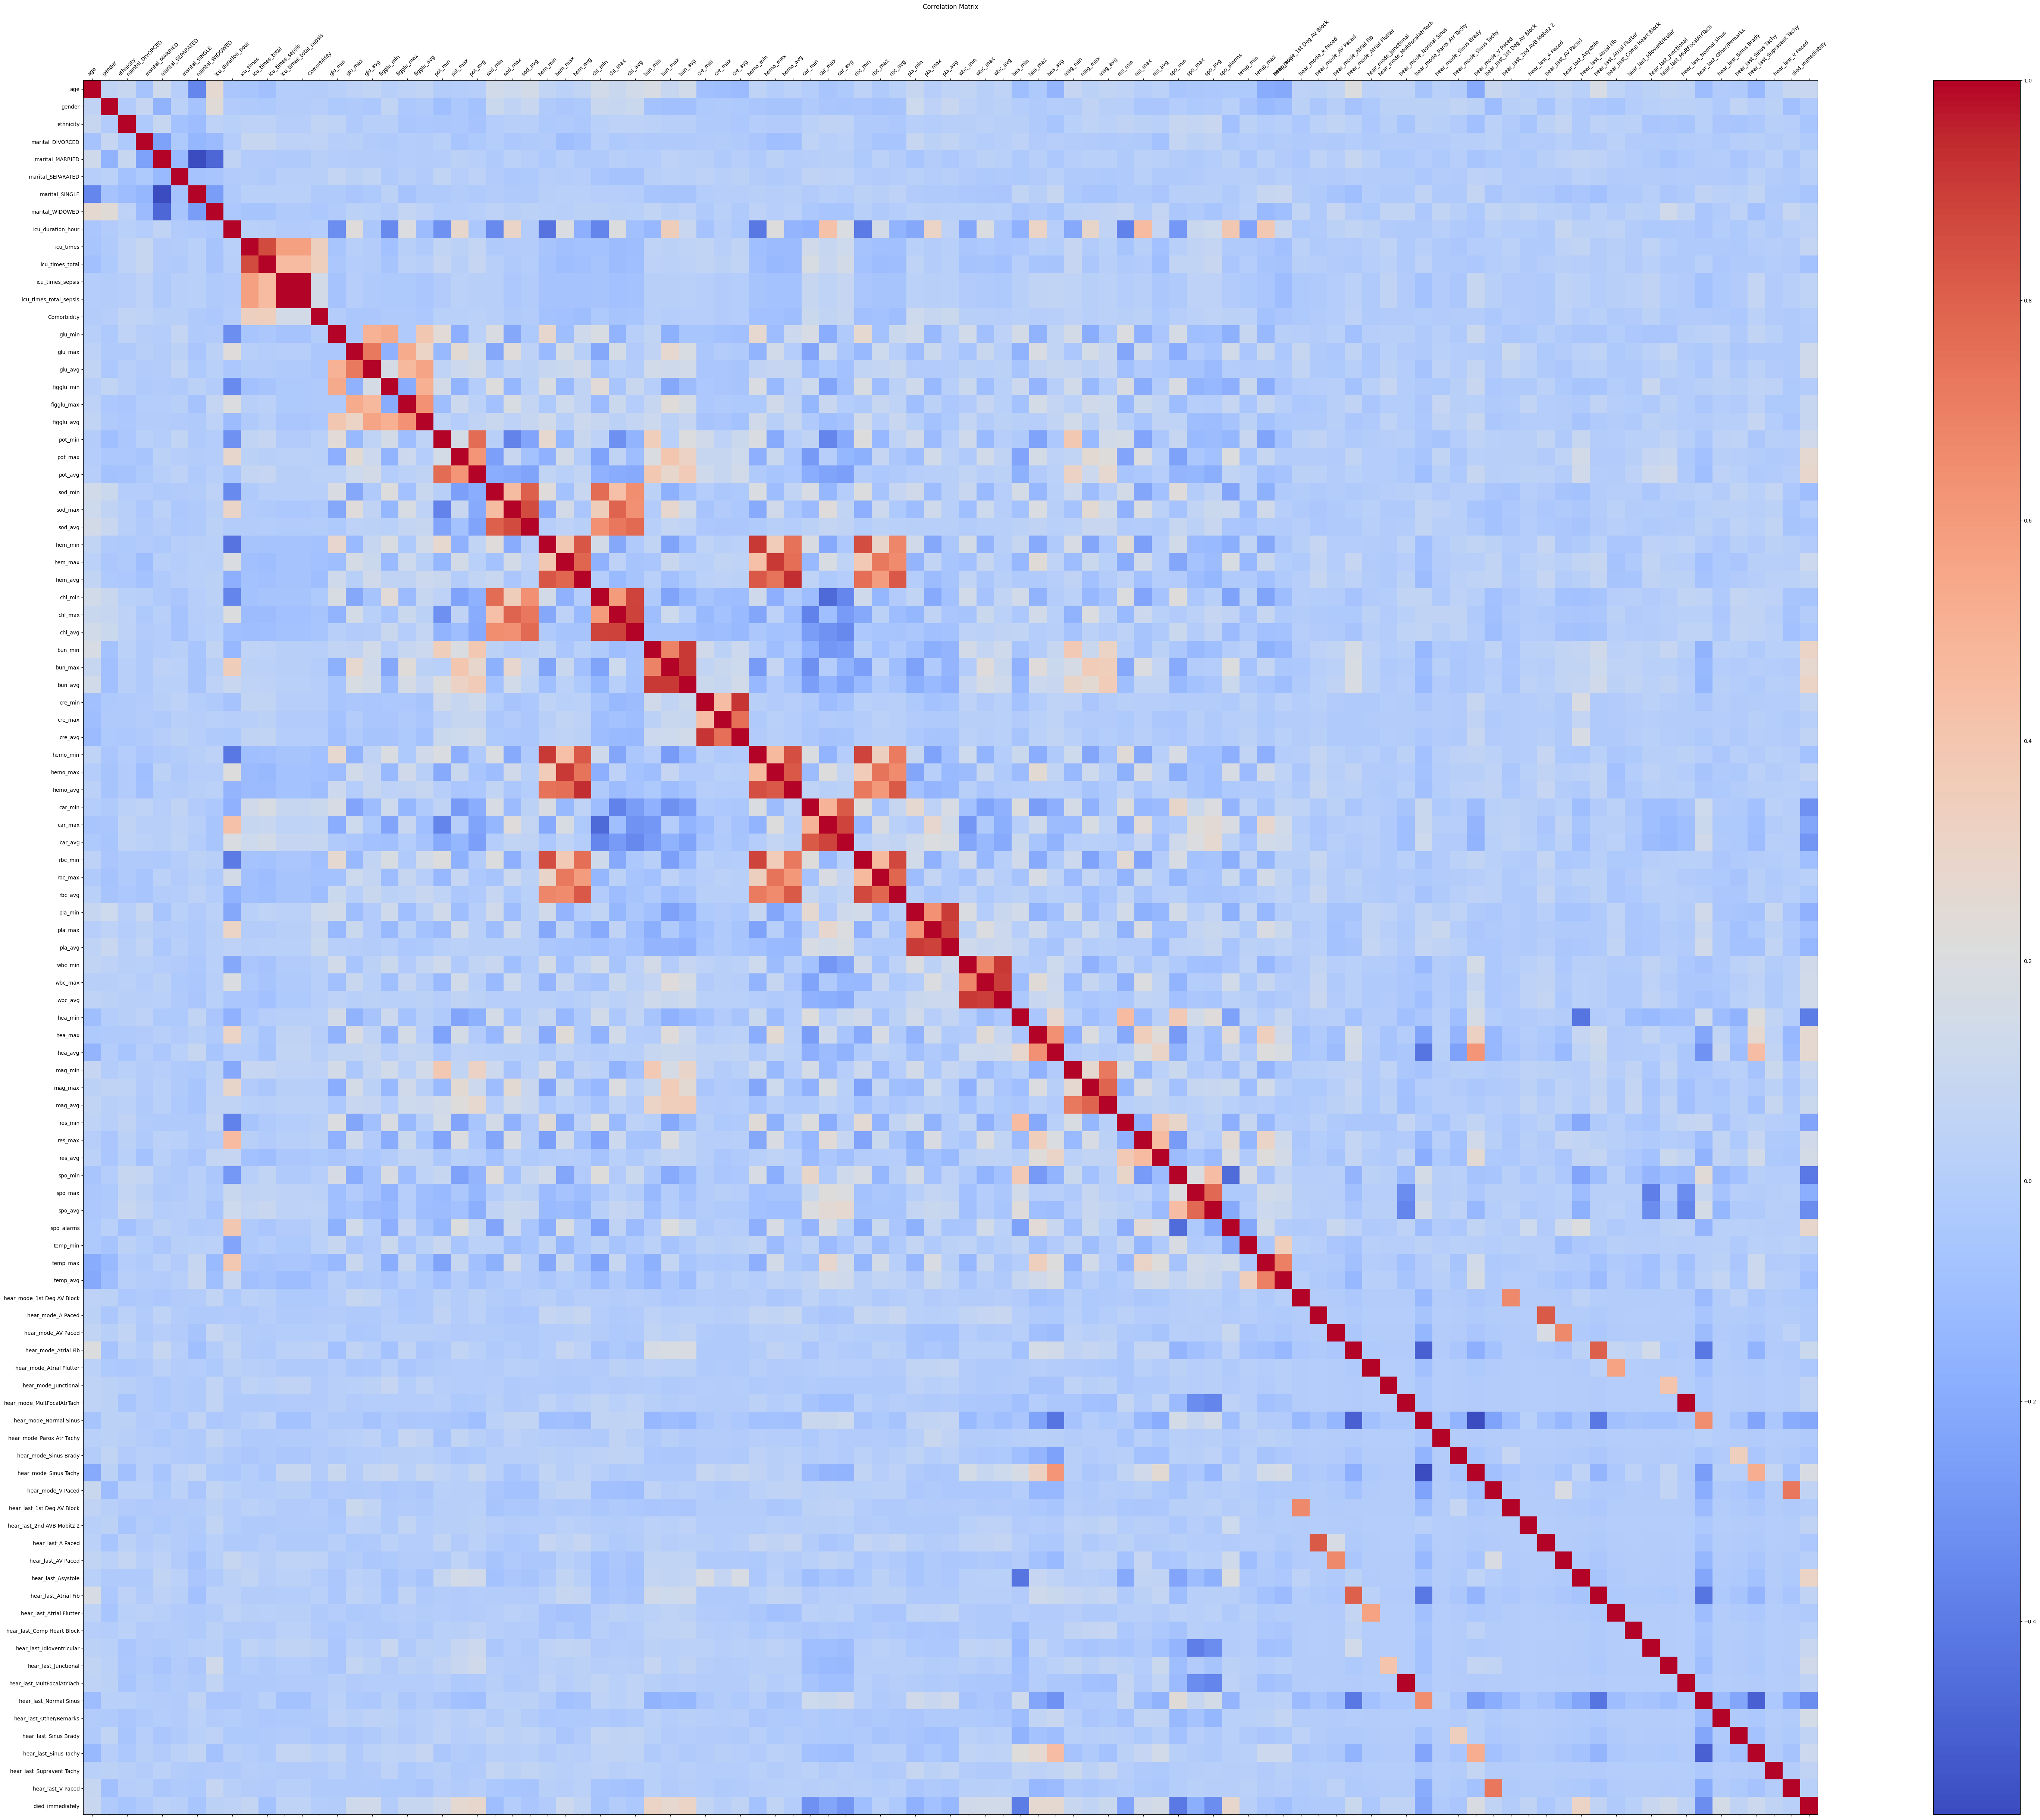

In [6]:
test_columns = list(data.columns[2:-3])
test_columns.append('died_immediately')

test_data = data[test_columns]
corr_matrix = test_data.corr()
plt.figure(figsize=(80, 60))
plt.matshow(corr_matrix, cmap="coolwarm", fignum=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix", pad=20)
plt.tight_layout()

plt.show()

corr_long = corr_matrix.reset_index().melt(id_vars='index')
corr_long.columns = ['Feature_1', 'Feature_2', 'Correlation'] 

corr_long.to_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\correlation_for_tableau.csv', index=False)

Corelation of features to target values.

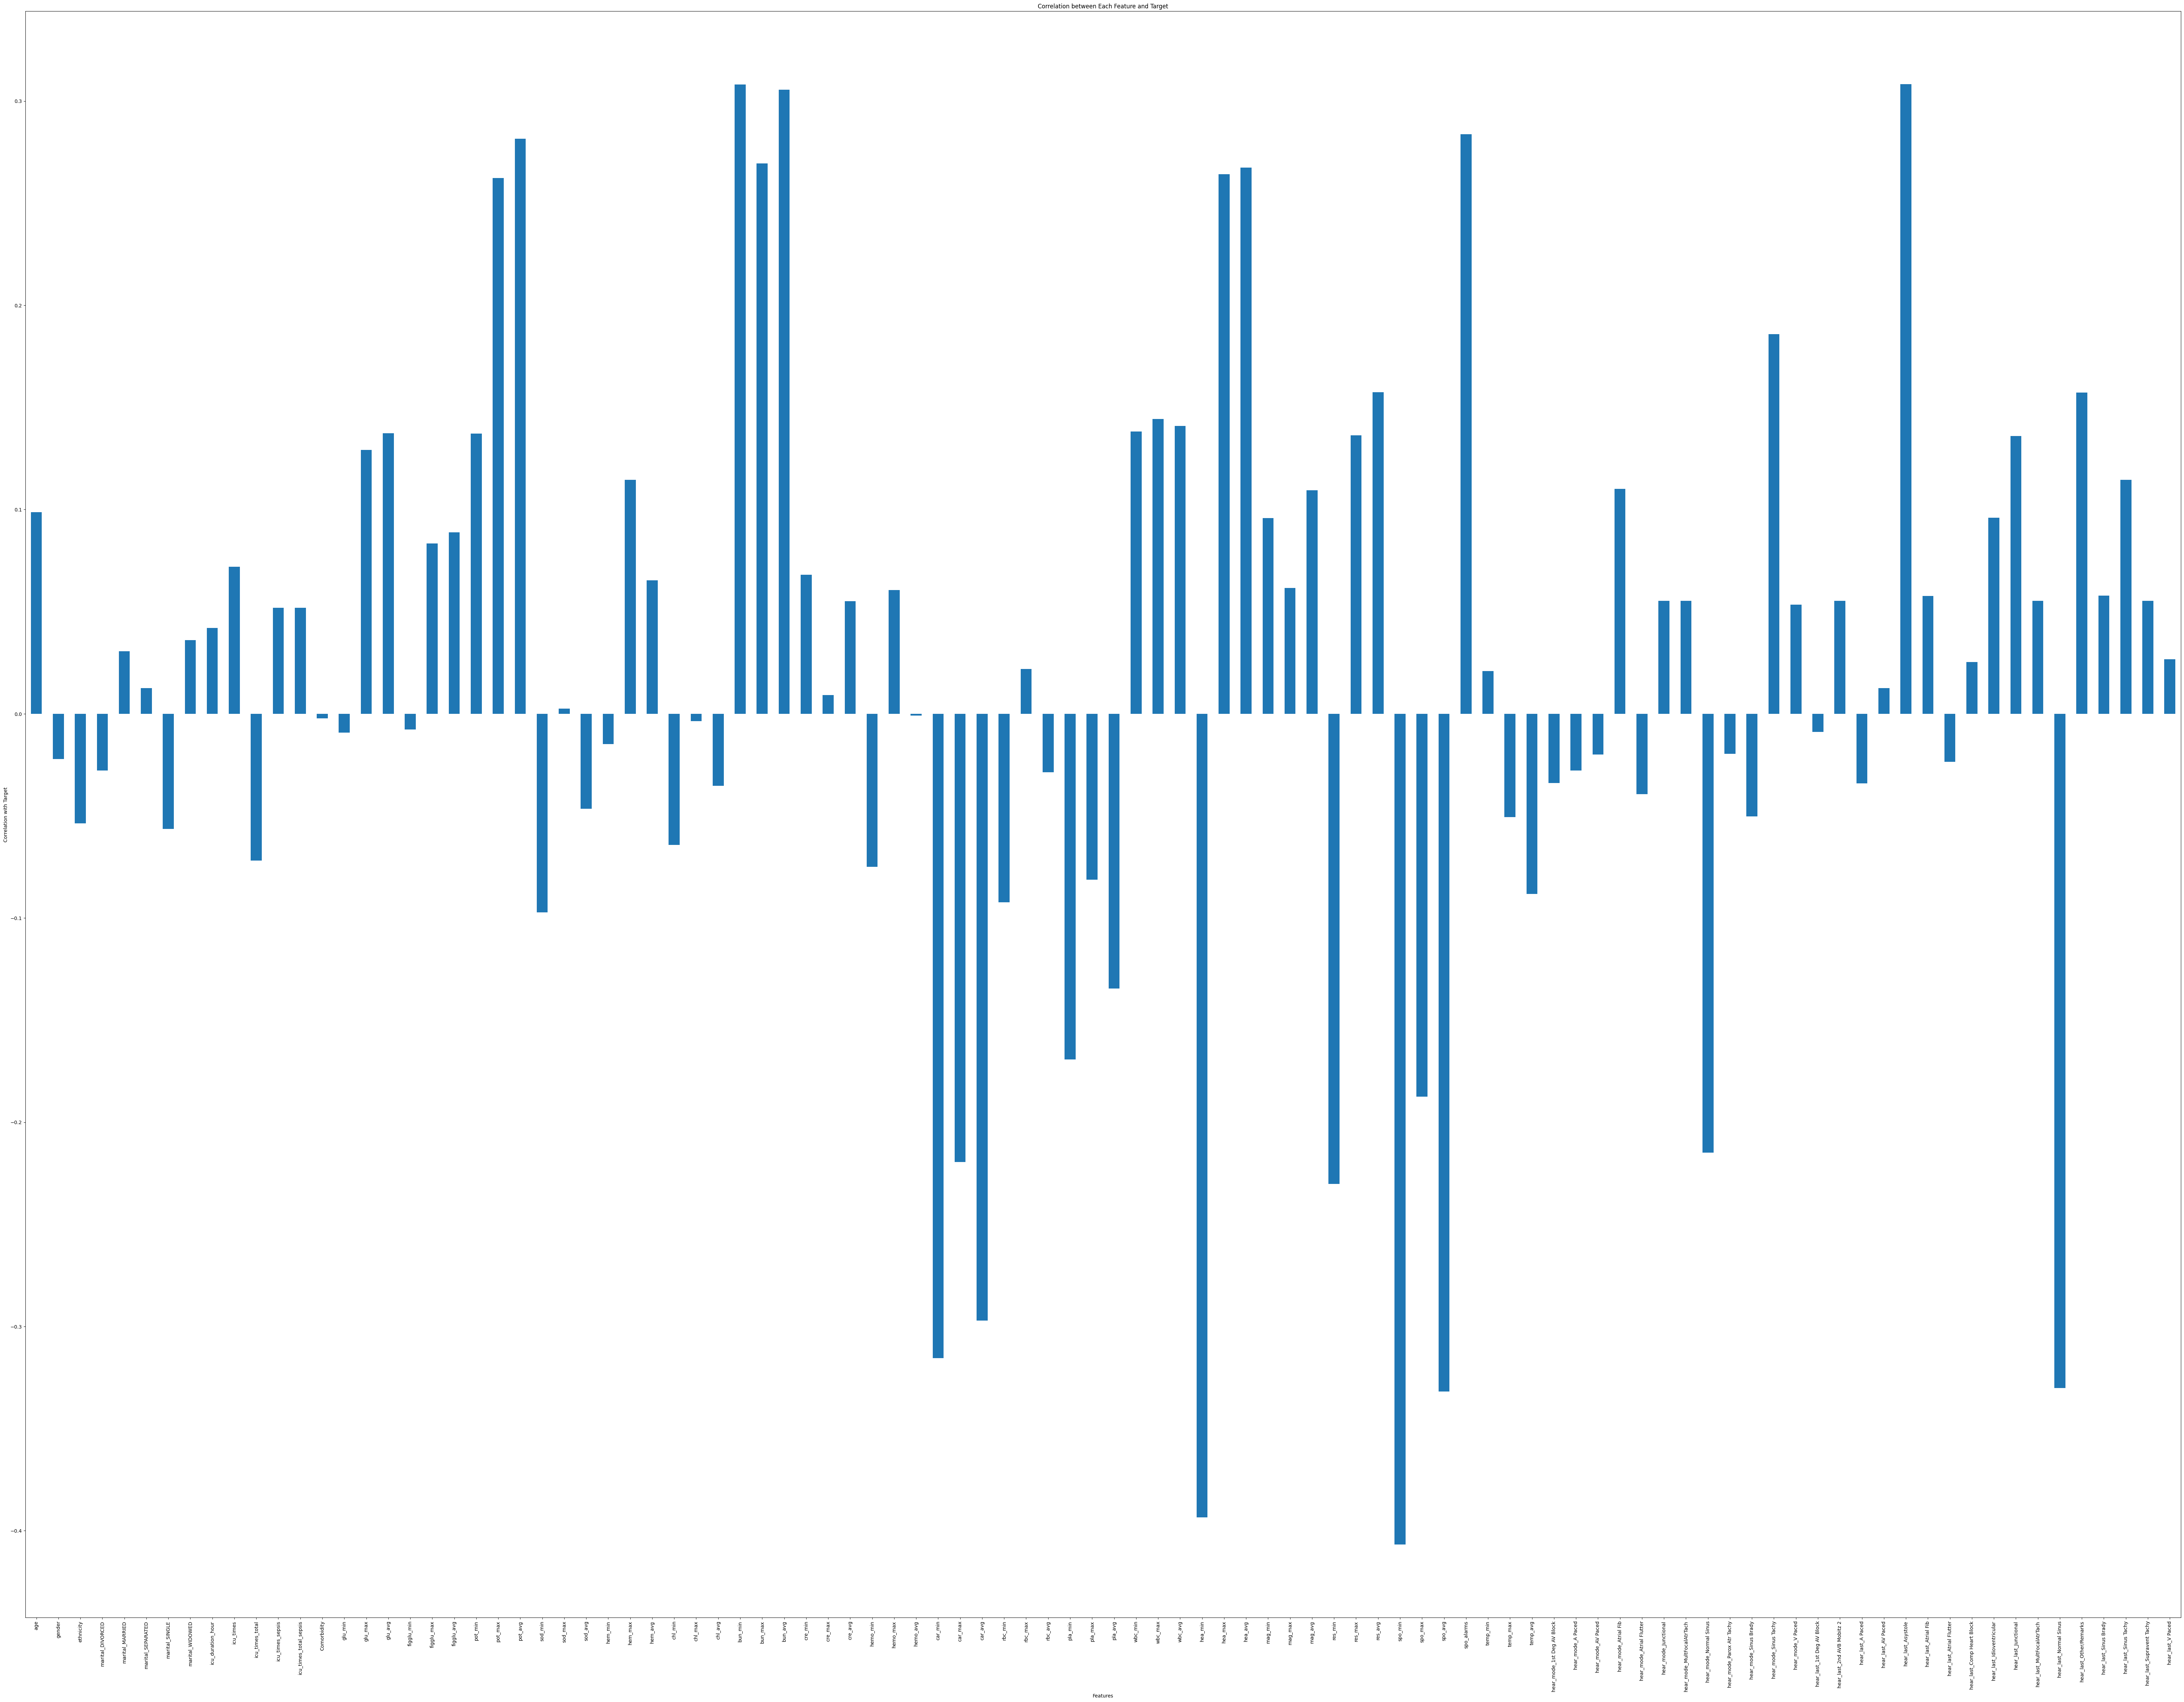

In [5]:
correlations = test_data.corr()['died_immediately'].drop('died_immediately') 

plt.figure(figsize=(80, 60))
correlations.plot(kind='bar')
plt.title("Correlation between Each Feature and Target")
plt.xlabel("Features")
plt.ylabel("Correlation with Target")
plt.show()

## **PART III: Feature & Model Selection --- RFE and Nested CV**

To evaluate model performance and identify the most important features, we first separate 20% of the dataset as a real test set. The remaining data is used for nested cross-validation, employing stratified 5-fold cross-validation for both the outer and inner loops.

**Outer Cross-Validation: Model Selection**

For model selection, we evaluate `Logistic Regression`, `Random Forest`, and `XGBoost` using their default hyperparameters. Within each outer-loop training set, these models are passed to the inner loop for feature selection.

**Inner Cross-Validation: Feature Selection**

Within the inner loop, based on the outer-loop training folds, we perform stratified 5-fold cross-validation to identify the most important features. To automate feature selection, we use `Recursive Feature Elimination (RFE)`. Specifically, the `RFECV` function is used to integrate feature selection and cross-validation seamlessly. When using XGBoost, we also incorporate a class weight hyperparameter based on the ratio of positive to negative classes. For each outer loop fold, the model will have a set of selected features from RFE. After completing the 5 folds in the outer loop for each model, we finalize the features that are selected more than half the time (i.e., selected in more than 2 out of the 5 folds) as the final set of features.
The selected features from the inner loop are then passed back to the outer loop to evaluate model performance.

**Results**

After completing nested cross-validation, we calculated the average model accuracy and identified the selected features for each model. To further analyze the impact of feature selection, we conducted additional experiments on datasets both with and without the inclusion of the "comorbidity" feature. While XGBoost did not achieve the highest performance among the three models, it selected fewer features, which reduced the feature dimensionality for the dataset without the "comorbidity" feature. This reduction in dimensionality can improve model inference speed. What's more, XGBoost is less sensitive to colinearlity.

Given these advantages, we chose to implement a stacked XGBoost model for prediction, as discussed in the next section.

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def nestedCV_RFE(path):
    data = pd.read_csv(path)
    X = data.drop(['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately'], axis=1)
    y = data['died_immediately']
    feature_names = X.columns

    X_train_total, X_test, y_train_total, y_test_total = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    

    scaler = MinMaxScaler()
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForestClassifier': RandomForestClassifier(),
        'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    trained_models = {'LogisticRegression': None,
        'RandomForestClassifier': None,
        'XGBClassifier': None
        }

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model_results = {}

    for model_name, model in models.items():
        outer_scores = []
        all_feature_sets = np.zeros((len(feature_names),))

        for train_index, test_index in outer_cv.split(X_train_total, y_train_total):
            X_train, X_test = X_train_total.iloc[train_index], X_train_total.iloc[test_index]
            y_train, y_test = y_train_total.iloc[train_index], y_train_total.iloc[test_index]
            X_train_scale = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(X_train_scale, columns=X_train.columns, index=X_train.index)
            X_test_scale = scaler.transform(X_test)
            X_test = pd.DataFrame(X_test_scale, columns=X_test.columns, index=X_test.index)

            if model_name == 'XGBClassifier':
                weight = y_train.value_counts()[0] / y_train.value_counts()[1]
                model.set_params(scale_pos_weight=weight)

            rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
            rfecv.fit(X_train, y_train)

            all_feature_sets += rfecv.support_

            model.fit(X_train.loc[:, rfecv.support_], y_train)
            y_pred = model.predict(X_test.loc[:, rfecv.support_])
            score = accuracy_score(y_test, y_pred)
            outer_scores.append(score)

        feature_indices = all_feature_sets > (outer_cv.n_splits / 2)  
        selected_features = [feature_names[i] for i, selected in enumerate(feature_indices) if selected]
        model_results[model_name] = {
            'Average Accuracy': np.mean(outer_scores),
            'Selected Features': selected_features
        }
        trained_models[model_name] = model
        print(f'model: {model_name}\nAvg Acc: {model_results[model_name]["Average Accuracy"]}\nSelected Features: {model_results[model_name]["Selected Features"]}\nFeature number: {len(model_results[model_name]["Selected Features"])}')

    best_model = max(model_results, key=lambda x: model_results[x]['Average Accuracy'])
    best_model_results = model_results[best_model]

    print(f"Best Model: {best_model}, with Average Accuracy: {best_model_results['Average Accuracy']}")
    print("Selected Features:", best_model_results['Selected Features'])
    


Without Comrobidity

In [ ]:
nestedCV_RFE(r'F:\\STUDY\\python_code\\Pract_DA\\prepocess\\cleaned_data\\cleaned_data_allfill.csv')

model: LogisticRegression
Avg Acc: 0.8479591836734693
Selected Features: ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 'figglu_min', 'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_max', 'hem_avg', 'bun_min', 'bun_avg', 'cre_avg', 'hemo_max', 'car_min', 'car_max', 'car_avg', 'pla_min', 'wbc_min', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 'hear_mode_Sinus Brady', 'hear_mode_Sinus Tachy', 'hear_mode_V Paced', 'hear_last_Asystole', 'hear_last_Atrial Fib', 'hear_last_Comp Heart Block', 'hear_last_Normal Sinus', 'hear_last_Other/Remarks', 'hear_last_Supravent Tachy', 'hear_last_V Paced']
Feature number: 49


With Comrobidity

In [ ]:
nestedCV_RFE('F:\\STUDY\\python_code\\Pract_DA\\prepocess\\cleaned_data\\cleaned_data_allfill_withComro.csv')

## **PART IV.Model Performance**
### 4.1 Single XGB Model
We frist separate the whole dataset into the training set and the real test set(20%), and used minmax scaler to do normalization on training set and test set separately. Then we trained and tested a single XGB model on this dataset. The only hyperparameter we use for XGB is 'scale_pos_weight', which is the ratio of the number of negative class to the number of positive class. To avoid randomness of the results caused by train_test_split, we use stratified 5-fold cross-validation to evaluate this model. The average recall for mortality is 0.65, and for survival is 0.93.

In [ ]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

path = r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv'
path = r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv'

data = pd.read_csv(path)

columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag','died_immediately']
X = data.drop(columns=columns_to_drop)
#X = X[['icu_times', 'icu_times_total', 'hear_last_Asystole', 'hear_last_Normal Sinus', 'hear_last_Other/Remarks']]
#X = X[['bun_min', 'bun_avg', 'car_avg', 'pla_avg', 'hea_min', 'hea_max', 'hea_avg', 'spo_min', 'spo_avg', 'spo_alarms']]
#X = X[['bun_min', 'bun_max', 'car_avg', 'pla_min', 'hea_min', 'hea_max', 'hea_avg', 'spo_min', 'spo_max', 'spo_alarms']]
#X = X[['icu_duration_hour', 'figglu_min', 'pot_avg', 'hem_avg', 'bun_min', 'bun_max', 'bun_avg', 'car_avg', 'pla_min', 
#       'pla_avg', 'wbc_min', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'res_min', 'res_avg', 'spo_min', 'spo_avg', 'spo_alarms']]
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]

scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X = pd.DataFrame(X_scale, columns=X.columns, index=X.index)


y = data['died_immediately']

skf = StratifiedKFold(n_splits=5, random_state=64, shuffle=True)

confusion_matrices = []

for train_index, test_index in skf.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

mean_cm = np.mean(confusion_matrices, axis=0)

mean_cm_df = pd.DataFrame(mean_cm, index=['SURVIVE', 'DIE'], columns=['SURVIVE', 'DIE'])

plt.figure(figsize=(5, 5))
sns.heatmap(mean_cm_df.T, cmap="Blues", annot=True, fmt=".2f", linecolor='black', linewidth=1, 
            xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Average Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predict')
plt.show()

TN, FP, FN, TP = mean_cm[0, 0], mean_cm[0, 1], mean_cm[1, 0], mean_cm[1, 1]

precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0

recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0

f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

accuracy = (TP + TN) / (TP + TN + FP + FN)

support_0 = TN + FP
support_1 = TP + FN

print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
print(f"Overall Accuracy: {accuracy:.4f}")

### 4.2 Stacked XGB Model
Then we use ensemble learning to try to improve the performance of the model. We utilized a linear regression to incorporate the output of three XGB models. To train this model, we firstly divide the training set into three sub dataset. Because the ratio of surviving patients to dead patients is approximately 3:1, each sub-training set is composed by combining 1/3 of the instances of surviving patients (non-repetitive sampling) with all instances of dead patients. To ensure a fair training environment for the three models, we maintain the same number of instances for prediction across all models. Therefore, despite using non-repetitive sampling for dividing the data of surviving patients as mentioned above, a very small number of patients are reused in practice to ensure that the number of instances in the dataset for training each XGBoost model is the same. Next, after predicting with the three XGBoost models on the complete training set, we will obtain three sets of predictions. These predictions will then be used as inputs for a linear regression model to fit the target value. This is the whole training process.

The prediction process for the stacked XGBoost models is as follows: The test data first passes through the three trained XGBoost models, and the outputs are then fed into a trained linear regression model to obtain the final predicted values. Since the output from the linear regression is a continuous value, we use 0.5 as a threshold to classify the predictions into two categories. Values less than 0.5 indicate survival, while values greater than 0.5 indicate death.

We use stratified cross-validation (CV) to validate the performance of the model. The results show that the stacked XGBoost model increases the recall of deceased patients by 6%, while it does not significantly affect the precision for surviving patients.
Therefore, we belived that XGB works the best.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

def train_stackXGB(X_train, y_train, thresh = 0.5):
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size=int(X_train_neg.shape[0]/3 + X_train_pos.shape[0])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []

    for train_idx, _ in skf.split(X_train_neg, y_train_neg):
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        num_neg = np.sum(y_fold == 0)
        num_pos = np.sum(y_fold == 1)
        scale_pos_weight = num_neg / num_pos

        model = xgb.XGBClassifier(#objective='binary:logistic', 
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  #reg_lambda = 5, 
                                  scale_pos_weight = scale_pos_weight
                                  #reg_alpha = 1
                                  )
        model.fit(X_fold, y_fold)
        models.append(model)

        pred = model.predict_proba(X_train)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    lin_reg = LinearRegression()
    lin_reg.fit(predictions, y_train)

    final_pred = lin_reg.predict(predictions)
    final_pred = (final_pred > 0.5).astype(int) 
    
    
    
    ########## normalize scores
    #if norm :
    #    print('niorm')
    #    stakxgb_scores = lin_reg.predict(predictions)
#
    #    mean_val = stakxgb_scores.mean()
    #    std_val = stakxgb_scores.std()
    #    standardized_scores = (stakxgb_scores - mean_val) / std_val
    #    min_val = standardized_scores.min()
    #    max_val = standardized_scores.max()
    #    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)
#
    #    final_pred = np.where(normalized_scores > thresh, 1,0) 

    print('Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)
    
    return models, lin_reg    

def test_models(models, lin_reg, X_test, y_test, thresh = 0.5, norm = False):
    print('Testing')
    test_predictions = []
    for model in models:
        pred = model.predict_proba(X_test)[:, 1] 
        test_predictions.append(pred)

    test_predictions = np.vstack(test_predictions).T

    final_pred = lin_reg.predict(test_predictions)

    final_pred_class = (final_pred > 0.5).astype(int) 
    
    #if norm:
    #    stakxgb_scores = lin_reg.predict(final_pred)
    #
    #    mean_val = stakxgb_scores.mean()
    #    std_val = stakxgb_scores.std()
    #    standardized_scores = (stakxgb_scores - mean_val) / std_val
    #    min_val = standardized_scores.min()
    #    max_val = standardized_scores.max()
    #    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)
#
    #    final_pred_class = np.where(normalized_scores > thresh, 1,0)  

    return final_pred_class
    

data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv')
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')

columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']
X = data.drop(columns=columns_to_drop)

# XGB
#X = X[['age', 'gender', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 'figglu_min', 
#       'figglu_max', 'figglu_avg', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_max', 'hem_avg', 'chl_max', 'chl_avg', 
#       'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'car_min', 'car_max', 'car_avg', 'rbc_min', 
#       'rbc_max', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_max', 
#       'res_min', 'res_max', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_1st Deg AV Block', 
#       'hear_last_Normal Sinus']]

y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

xgbs, lin_reg = train_stackXGB(X_train, y_train)

final_pred_class = test_models(xgbs, lin_reg, X_test, y_test)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))




def cross_validate_models(X, y, norm = False,n_splits=5):
    if norm:
        print('norm')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        xgbs, lin_reg = train_stackXGB(X_train, y_train, norm)
        
        final_pred_class = test_models(xgbs, lin_reg, X_test, y_test, norm)
        
        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")

cross_validate_models(X, y, norm=True)

### 4.3 One class SVM 
Given that the dataset is imbalanced, we can adopt an alternative approach by using anomaly detection to predict patient mortality. One-class SVM is an excellent model for anomaly detection. This model uses unsupervised learning to capture the characteristics of the negative class (the majority class). It then determines whether new instances conform to the features of the majority class. Instances that do not fit are considered anomalies.

We applied the One-Class SVM (OCSVM) to our dataset and found that OCSVM tends to predict patients as dead. For the hyperparameters of the One-Class SVM (OCSVM), we use the RBF kernel because it is commonly used to handle nonlinear problems. The hyperparameter `nu` is set to 0.25, indicating that approximately 25% of the data is considered as anomalies. The `gamma` parameter is set to 0.7, determined through a suboptimal method of repeated trials rather than cross-validation. However, the stacked XGBoost model performs better in accurately predicting surviving patients. Therefore, we decided to integrate stacked XGBoost with OCSVM once again for ensemble learning. Additionally, we discovered that by obtaining the distance of each data point from the SVM hyperplane, standardizing these distances (to avoid extreme values affecting the distribution), and then normalizing them (converting distances to a range of 0-1), these distances can be interpreted as probabilities of being identified as anomalies. According to the default decision boundary of OCSVM, after transformation, the classification threshold should be 0.5 (greater than 0.5 for survival, less than 0.5 for death). However, after several trials, we found that 0.45 is a more suitable threshold. Although we have not delved deeper into this issue due to time constraints, and this thresholding method has not yet been applied in subsequent ensemble learning models, it merits further research.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

path = r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv'

data = pd.read_csv(path)
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')


columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag']
X = data.drop(columns=columns_to_drop)
y = data['died_immediately']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64, stratify=y)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

scaler = MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

X_0 = x_train_scaled[y_train == 0].drop(columns=['died_immediately'])
X_1 = x_test_scaled[y_test == 1].drop(columns=['died_immediately'])
clf = OneClassSVM(nu=0.25, kernel="rbf", gamma=0.7)
clf.fit(X_0)


y_pred = clf.predict(x_test_scaled.drop(columns=['died_immediately']))
y_pred = np.where(y_pred == 1, 0, 1)  

labels = ['SURVIVE', 'DIE']
CM = confusion_matrix(y_test, y_pred)
CM = pd.DataFrame(CM, index=labels, columns=labels)

plt.figure(figsize=(8, 8))
sns.heatmap(CM.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels, annot_kws={"fontsize": 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('True', fontsize=15)
plt.ylabel('Pred', fontsize=15)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))


svm_scores = clf.decision_function(x_test_scaled.drop(columns=['died_immediately']))
mean_val = svm_scores.mean()
std_val = svm_scores.std()
standardized_scores = (svm_scores - mean_val) / std_val
min_val = standardized_scores.min()
max_val = standardized_scores.max()
normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

#remains to be done
thresh_norm = (0 - min_val) / (max_val - min_val)
print(thresh_norm)

y_pred = np.where(normalized_scores > 0.45, 0,1)


labels = ['SURVIVE', 'DIE']
CM = confusion_matrix(y_test, y_pred)
CM = pd.DataFrame(CM, index=labels, columns=labels)

plt.figure(figsize=(8, 8))
sns.heatmap(CM.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels, annot_kws={"fontsize": 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('True', fontsize=15)
plt.ylabel('Pred', fontsize=15)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))



### 4.4 Stack XGB + OCSVM

We further refined our model by fitting the outputs of the stacked XGBoost linear regression with the distances of data points from the decision boundary obtained via OCSVM (which were standardized and normalized) using another linear regression to generate final predictions. Despite this innovative approach, applying the stacked XGBoost + OCSVM model on the complete dataset did not result in significant performance improvements.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
import seaborn as sns

def train_stackXGB(X_train, y_train):
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size=int(X_train_neg.shape[0]/3 + X_train_pos.shape[0])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []

    for train_idx, _ in skf.split(X_train_neg, y_train_neg):
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        num_neg = np.sum(y_fold == 0)
        num_pos = np.sum(y_fold == 1)
        scale_pos_weight = num_neg / num_pos

        model = xgb.XGBClassifier(#objective='binary:logistic', 
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  #reg_lambda = 5, 
                                  scale_pos_weight = scale_pos_weight
                                  #reg_alpha = 1
                                  )
        model.fit(X_fold, y_fold)
        models.append(model)

        pred = model.predict_proba(X_train)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    lin_reg = LinearRegression()
    lin_reg.fit(predictions, y_train)

    final_pred = lin_reg.predict(predictions)
    final_pred = (final_pred > 0.5).astype(int) 
    
    print('Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)
    
    return models, lin_reg    

def train_one_class_svm(X_train, y_train):
    svm_train_X = X_train[y_train == 0] 
    oc_svm = OneClassSVM(nu=0.25, kernel="rbf", gamma=0.7)
    oc_svm.fit(svm_train_X)
    print('OCSVM Train finish')
    
    return oc_svm

def combined_train(X_train, y_train):
    xgbs, lin_reg_xgb = train_stackXGB(X_train, y_train)
    xgb_predictions = []
    for model in xgbs:
        pred = model.predict_proba(X_train)[:, 1] 
        xgb_predictions.append(pred)

    xgb_predictions = np.vstack(xgb_predictions).T
    stakxgb_pred = lin_reg_xgb.predict(xgb_predictions).reshape(-1, 1)
    #stakxgb_pred = (stakxgb_pred > 0.5).astype(int) 
    

    ocsvm = train_one_class_svm(X_train, y_train)
    svm_scores = ocsvm.decision_function(X_train)
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)
    print(thresh)

    ocsvm_pred = normalized_scores.reshape(-1, 1)
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1).reshape(-1, 1)

    
    print(stakxgb_pred.shape)
    print(ocsvm_pred.shape)
    
    combined_predictions = np.hstack([stakxgb_pred, ocsvm_pred])


    final_lin_reg = LinearRegression()
    final_lin_reg.fit(combined_predictions, y_train)
    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    

    
    print('Final Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)

    return xgbs, lin_reg_xgb, ocsvm,final_lin_reg


def test_models(models, lin_reg_xgb, ocsvm, final_lin_reg, X_test):
    print('Testing')
    predictions = []
    for model in models:
        pred = model.predict_proba(X_test)[:, 1] 
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    
    svm_scores = ocsvm.decision_function(X_test)
    #print(svm_scores)
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)

    
    ocsvm_pred = normalized_scores
    #print(ocsvm_pred)
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1)
    
    combined_predictions = np.hstack([stakxgb_pred.reshape(-1, 1), ocsvm_pred.reshape(-1, 1)])
    #print(combined_predictions)
    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    
    return final_pred
    



def cross_validate_models(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train)
        
        final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test)

        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")


### 4.5 Flashback to RFE feature selection
To identify the most effective features according to the One-Class SVM (OCSVM), we employed cross-validation again. However, because OCSVM uses a non-linear RBF kernel, it does not provide coefficient values for each feature. To address this challenge, we adopted a suboptimal method: we applied OCSVM to the feature sets previously selected by random forest, logistic regression, and XGBoost individually. We then evaluated the average accuracy of OCSVM on these feature sets and selected the set with the highest accuracy as the features deemed most important by OCSVM. The results indicate that the OCSVM selected the features chosen by logistic regression.
It is worth noting that none of the models selected the comorbidity feature. There are two possible explanations for this. The first is that, although sepsis is often caused by other illnesses, having multiple diseases does not significantly impact a patient's survival rate. The second explanation is that the dataset does not clearly indicate the diseases causing sepsis in patients; we can only infer a patient's comorbidities from hospital admission records. However, ultimately, out of nearly a thousand individuals, only slightly more than a hundred were considered to have comorbidities. This clearly indicates suboptimal results. Perhaps further exploration of the dataset is needed.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


def train_stackXGB(X_train, y_train):
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size=int(X_train_neg.shape[0]/3 + X_train_pos.shape[0])
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []

    for train_idx, _ in skf.split(X_train_neg, y_train_neg):
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        num_neg = np.sum(y_fold == 0)
        num_pos = np.sum(y_fold == 1)
        scale_pos_weight = num_neg / num_pos
        model = xgb.XGBClassifier(#objective='binary:logistic', 
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  #reg_lambda = 5, 
                                  scale_pos_weight = scale_pos_weight
                                  #reg_alpha = 1
                                  )
        model.fit(X_fold, y_fold)
        models.append(model)

        pred = model.predict_proba(X_fold)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T

    
    lin_reg_xgb = LinearRegression()
    lin_reg_xgb.fit(predictions, y_fold)
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    stakxgb_pred = (stakxgb_pred > 0.5).astype(int)
    stakxgb_pred = stakxgb_pred.reshape(-1, 1)
    
    
    print('Stack XGB Train result')
    print(classification_report(y_fold, stakxgb_pred))
    cm = confusion_matrix(y_fold, stakxgb_pred)
    print(cm)
    
    return models, lin_reg_xgb 

def train_one_class_svm(X_train, y_train):
    svm_train_X = X_train[y_train == 0] 
    oc_svm = OneClassSVM(nu=0.001, kernel="rbf", gamma=0.7)
    oc_svm.fit(svm_train_X)
    print('OCSVM Train finish')
    
    return oc_svm

def combined_train(X_train, y_train, features):
    xgb_feature = features['XGB']
    xgbs, lin_reg_xgb = train_stackXGB(X_train[xgb_feature], y_train)
    xgb_predictions = []
    for model in xgbs:
        pred = model.predict_proba(X_train[xgb_feature])[:, 1] 
        xgb_predictions.append(pred)

    xgb_predictions = np.vstack(xgb_predictions).T
    stakxgb_pred = lin_reg_xgb.predict(xgb_predictions).reshape(-1, 1)
    #stakxgb_pred = (stakxgb_pred > 0.5).astype(int) 
    
    svm_feature = features['OCSVM']
    ocsvm = train_one_class_svm(X_train[svm_feature], y_train)
    svm_scores = ocsvm.decision_function(X_train[svm_feature])
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)
    print(thresh)

    ocsvm_pred = normalized_scores.reshape(-1, 1)
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1).reshape(-1, 1)

    
    print(stakxgb_pred.shape)
    print(ocsvm_pred.shape)
    
    combined_predictions = np.hstack([stakxgb_pred, ocsvm_pred])


    final_lin_reg = LinearRegression()
    final_lin_reg.fit(combined_predictions, y_train)
    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    

    
    print('Final Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)

    return xgbs, lin_reg_xgb, ocsvm,final_lin_reg


def test_models(models, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features):
    print('Testing')
    xgb_feature = features['XGB']
    predictions = []
    for model in models:
        pred = model.predict_proba(X_test[xgb_feature])[:, 1] 
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    
    svm_feature = features['OCSVM']
    svm_scores = ocsvm.decision_function(X_test[svm_feature])
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)

    
    ocsvm_pred = normalized_scores
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1)
    
    combined_predictions = np.hstack([stakxgb_pred.reshape(-1, 1), ocsvm_pred.reshape(-1, 1)])

    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    
    return final_pred







data = pd.read_csv('F:\\STUDY\\python_code\\Pract_DA\\prepocess\\cleaned_data\\cleaned_data_allfill_withComro.csv')
X = data.drop(['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately'], axis=1)
y = data['died_immediately']
feature_names = X.columns

X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
  

############## 放在cv里面 ####################
#scaler = MinMaxScaler()
#X_train_total = scaler.fit_transform(X_train)
#X_train_total = pd.DataFrame(X_train_total, columns=X_train.columns, index=X_train.index)
#X_test_total = scaler.transform(X_test)
#X_test_total = pd.DataFrame(X_test_total, columns=X_test.columns, index=X_test.index)


models = {
    'OCSVM': OneClassSVM(nu=0.001, kernel="rbf", gamma=0.7),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

trained_models = {'OCSVM': None,
    'XGB': None
    }

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_results = {}


for train_index, test_index in outer_cv.split(X_train_total, y_train_total):
    X_train, X_test = X_train_total.iloc[train_index], X_train_total.iloc[test_index]
    y_train, y_test = y_train_total.iloc[train_index], y_train_total.iloc[test_index]
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scale, columns=X_train.columns, index=X_train.index)
    X_test_scale = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scale, columns=X_test.columns, index=X_test.index)
    accuracies = []  
    all_cm = [] 
    features= {}
    for model_name, model in models.items():   
        if model_name == 'XGB':
            outer_scores = []
            all_feature_sets = np.zeros((len(feature_names),)) 
            inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            for train_index, test_index in skf.split(X_train[feature_], y_train):
                X_train_sub = X_train.iloc[train_index]
                X_test_sub = X_train.iloc[test_index]
                y_train_sub = y_train.iloc[train_index]
                y_test_sub = y_train.iloc[test_index]
                weight = y_train_sub.value_counts()[0] / y_train.value_counts()[1]
                model.set_params(scale_pos_weight=weight)

                rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
                rfecv.fit(X_train, y_train)

                all_feature_sets += rfecv.support_

                model.fit(X_train.loc[:, rfecv.support_], y_train)
                y_pred = model.predict(X_test.loc[:, rfecv.support_])
                score = accuracy_score(y_test, y_pred)
                outer_scores.append(score)

            feature_indices = all_feature_sets > (inner_cv.n_splits / 2)  
            selected_features = [feature_names[i] for i, selected in enumerate(feature_indices) if selected]

            model_results[model_name] = {
                'Average Accuracy': np.mean(outer_scores),
                'Selected Features': selected_features
            }
            features[model_name] = selected_features
            #trained_models[model_name] = model
            #print(f'model: {model_name}\nAvg Acc: {model_results[model_name]["Average Accuracy"]}\nSelected Features: {model_results[model_name]["Selected Features"]}\nFeature number: {len(model_results[model_name]["Selected Features"])}')

        elif model_name == "OCSVM":
            modelSelectedFeatures = {
                'LogiR': ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 
                          'figglu_min', 'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_max', 'hem_avg', 
                          'bun_min', 'bun_avg', 'cre_avg', 'hemo_max', 'car_min', 'car_max', 'car_avg', 'pla_min', 'wbc_min', 'hea_min',
                          'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_min',
                          'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 'hear_mode_Sinus Brady', 
                          'hear_mode_Sinus Tachy', 'hear_mode_V Paced', 'hear_last_Asystole', 'hear_last_Atrial Fib', 
                          'hear_last_Normal Sinus', 'hear_last_Other/Remarks', 'hear_last_Supravent Tachy', 'hear_last_V Paced'],
                'RF': ['age', 'icu_duration_hour', 'glu_min', 'glu_avg', 'figglu_min', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 
                       'sod_min', 'sod_avg', 'hem_min', 'hem_max', 'hem_avg', 'chl_min', 'chl_max', 'chl_avg', 'bun_min', 'bun_max', 
                       'bun_avg', 'hemo_min', 'hemo_max', 'hemo_avg', 'car_min', 'car_max', 'car_avg', 'rbc_min', 'pla_min', 'pla_max', 
                       'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'mag_avg', 'res_min', 
                       'res_max', 'res_avg', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_Asystole',
                       'hear_last_Normal Sinus'],
                "XGB": ['age', 'gender', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 
                        'figglu_min', 'figglu_max', 'figglu_avg', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_max', 'hem_avg', 
                        'chl_max', 'chl_avg', 'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'car_min', 
                        'car_max', 'car_avg', 'rbc_min', 'rbc_max', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 
                        'hea_min', 'hea_max', 'hea_avg', 'mag_max', 'res_min', 'res_max', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 
                        'temp_max', 'temp_avg', 'hear_last_1st Deg AV Block', 'hear_last_Normal Sinus']    
            }
            skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
            best_model = None
            best_score = 0
            model_performance = {}
            for model_name_, feature_ in modelSelectedFeatures.items():
                recall_scores = []
                accuracy_scores = []

                for train_index, test_index in skf.split(X_train[feature_], y_train):
                    X_train_sub = X_train.iloc[train_index]
                    X_test_sub = X_train.iloc[test_index]
                    y_train_sub = y_train.iloc[train_index]
                    y_test_sub = y_train.iloc[test_index]
                    
                    ocsvm = train_one_class_svm(X_train_sub,y_train_sub)
                    y_pred = ocsvm.predict(X_test_sub)
                    y_pred = np.where(y_pred == 1, 0, 1)
                    
                    recall = recall_score(y_test_sub, y_pred, pos_label=1)
                    accuracy = accuracy_score(y_test_sub, y_pred)
                    recall_scores.append(recall)
                    accuracy_scores.append(accuracy)
                    avg_recall = np.mean(recall_scores)
                avg_accuracy = np.mean(accuracy_scores)
                model_performance[model_name_] = {'recall': avg_recall, 'accuracy': avg_accuracy}

                print(f"Model: {model_name_}, Recall: {avg_recall:.4f}, Accuracy: {avg_accuracy:.4f}")

                if avg_recall > best_score:
                    best_score = avg_recall
                    best_model = model_name_

            print(f"Best Model: {best_model} with Best Recall: {best_score:.4f}")
            features[model_name] = modelSelectedFeatures[best_model]
            
    print(features)    
    xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train, features)
    final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features)
    
    accuracy = accuracy_score(y_test, final_pred_class)
    cm = confusion_matrix(y_test, final_pred_class)
    
    accuracies.append(accuracy)
    all_cm.append(cm)

mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {mean_accuracy:.4f}")
mean_cm = np.mean(all_cm, axis=0)
plt.figure(figsize=(5,5))
sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Mean Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
TN, FP = mean_cm[0, 0], mean_cm[0, 1]
FN, TP = mean_cm[1, 0], mean_cm[1, 1]

precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0

recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0

f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

accuracy = (TP + TN) / (TP + TN + FP + FN)

support_0 = TN + FP
support_1 = TP + FN

print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
print(f"Overall Accuracy: {accuracy:.4f}")
    
    


### 4.6 Change stack models
We attempted to switch the stacking model, replacing the stacked XGBoost with stacked Random Forest (excluding OCSVM), but there was no significant difference in model performance. We then changed the stacking model again to include Random Forest, XGBoost, and Logistic Regression (without OCSVM). This change significantly improved the model's performance in predicting deceased patients (by +8%), but the performance in predicting surviving patients dramatically declined (by -10%).

Subsequently, we added OCSVM to the stacked RF + Logistic Regression + XGBoost model, which again improved the model's performance, reaching a level similar to the original stacked XGBoost + OCSVM model. We also changed all linear regression in the ensemble models to logistic regression, and the performances did not change too much.

The code for this part will be skipped to make the report more precise. Detailed code can be found in Github.

### 4.7 Consider selected feature
We incorporated features selected by Recursive Feature Elimination (RFE) for each model into the training process. While the performance of the stacked XGBoost + OCSVM model showed no significant change (code skipped), the stacked Random Forest/Logistic Regression/XGBoost + OCSVM model experienced a remarkable improvement in accuracy. The classification recall for both surviving and deceased patients reached 94%. Although we are pleasantly surprised by this outcome, a satisfactory explanation for these results still remains to be found.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
import seaborn as sns

def train_stackXGB(X_train, y_train, features):
    model_list = [
        ('Logi', LogisticRegression(max_iter=1000)),
        ('RF', RandomForestClassifier()),
        ('XGB', xgb.XGBClassifier())  # XGBoost 模型预先定义，权重稍后设置
    ]
    
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size = int(X_train_neg.shape[0] / 3 + X_train_pos.shape[0])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []
    
    for fold_num, (train_idx, _) in enumerate(skf.split(X_train_neg, y_train_neg)):
        model_name, model = model_list[fold_num % len(model_list)]
        feature = features[model_name]
        
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        scaler = MinMaxScaler()

        X_train_scaled = scaler.fit_transform(X_fold)
        X_fold = pd.DataFrame(X_train_scaled, columns=X_fold.columns, index=X_fold.index)
        #选feature
        
        
        if model_name == 'XGB':
            num_neg = np.sum(y_fold == 0)
            num_pos = np.sum(y_fold == 1)
            scale_pos_weight = num_neg / num_pos
            model.set_params(scale_pos_weight=scale_pos_weight)
        
        model.fit(X_fold[feature], y_fold)
        models.append(model)
        scaler = MinMaxScaler()

        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        # 选择feature
        
        pred = model.predict_proba(X_train[feature])[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    lin_reg = LinearRegression()
    lin_reg.fit(predictions, y_train)  
    
    return models, lin_reg

def train_one_class_svm(X_train, y_train):
    svm_train_X = X_train[y_train == 0] 
    oc_svm = OneClassSVM(nu=0.25, kernel="rbf", gamma=0.7)
    oc_svm.fit(svm_train_X)
    print('OCSVM Train finish')
    
    return oc_svm

def combined_train(X_train, y_train, features):
    xgbs, lin_reg_xgb = train_stackXGB(X_train, y_train, features)
    xgb_predictions = []
    models = ['Logi', 'RF', "XGB"]
    for idx, model in enumerate(xgbs):
        feature = features[models[idx]]
        pred = model.predict_proba(X_train[feature])[:, 1] 
        xgb_predictions.append(pred)

    xgb_predictions = np.vstack(xgb_predictions).T
    stakxgb_pred = lin_reg_xgb.predict(xgb_predictions).reshape(-1, 1)
    #stakxgb_pred = (stakxgb_pred > 0.5).astype(int) 
    

    ocsvm = train_one_class_svm(X_train[features['OCSVM']], y_train)
    svm_scores = ocsvm.decision_function(X_train[features['OCSVM']])
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)
    print(thresh)

    ocsvm_pred = normalized_scores.reshape(-1, 1)
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1).reshape(-1, 1)

    
    print(stakxgb_pred.shape)
    print(ocsvm_pred.shape)
    
    combined_predictions = np.hstack([stakxgb_pred, ocsvm_pred])


    final_lin_reg = LinearRegression()
    final_lin_reg.fit(combined_predictions, y_train)
    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    

    
    print('Final Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)

    return xgbs, lin_reg_xgb, ocsvm,final_lin_reg


def test_models(models, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features):
    print('Testing')
    predictions = []
    models = ['Logi', 'RF', "XGB"]
    for idx, model in enumerate(xgbs):
        feature = features[models[idx]]
        pred = model.predict_proba(X_test[feature])[:, 1] 
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    
    svm_scores = ocsvm.decision_function(X_test[features['OCSVM']])
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)

    
    ocsvm_pred = normalized_scores
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1)
    
    combined_predictions = np.hstack([stakxgb_pred.reshape(-1, 1), ocsvm_pred.reshape(-1, 1)])

    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    
    return final_pred
    



def cross_validate_models(X, y, features, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []  
    all_cm = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train, features)
        
        final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features)

        accuracy = accuracy_score(y_test, final_pred_class)
        cm = confusion_matrix(y_test, final_pred_class)
        print("Classification Report:\n", classification_report(y_test, final_pred_class))
        
        accuracies.append(accuracy)
        all_cm.append(cm)

    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    mean_cm = np.mean(all_cm, axis=0)
    plt.figure(figsize=(5,5))
    sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
    plt.title('Mean Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    TN, FP = mean_cm[0, 0], mean_cm[0, 1]
    FN, TP = mean_cm[1, 0], mean_cm[1, 1]
    
    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    support_0 = TN + FP
    support_1 = TP + FN
    
    print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
    print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
    print(f"Overall Accuracy: {accuracy:.4f}")


#data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill.csv')
data = pd.read_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\cleaned_data\cleaned_data_allfill_withComro.csv')
columns_to_drop = ['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately']

features = {'OCSVM': ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 
          'figglu_min', 'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_max', 'hem_avg', 
          'bun_min', 'bun_avg', 'cre_avg', 'hemo_max', 'car_min', 'car_max', 'car_avg', 'pla_min', 'wbc_min', 'hea_min',
          'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_min',
          'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 'hear_mode_Sinus Brady', 
          'hear_mode_Sinus Tachy', 'hear_mode_V Paced', 'hear_last_Asystole', 'hear_last_Atrial Fib', 
          'hear_last_Normal Sinus', 'hear_last_Other/Remarks', 'hear_last_Supravent Tachy', 'hear_last_V Paced'], 
 'XGB': ['age', 'gender', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 
         'figglu_min', 'figglu_max', 'figglu_avg', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_max', 'hem_avg', 
         'chl_max', 'chl_avg', 'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'car_min', 
         'car_max', 'car_avg', 'rbc_min', 'rbc_max', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 
         'hea_min', 'hea_max', 'hea_avg', 'mag_max', 'res_min', 'res_max', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 
         'temp_max', 'temp_avg', 'hear_last_1st Deg AV Block', 'hear_last_Normal Sinus'],
 'RF': ['age', 'icu_duration_hour', 'glu_min', 'glu_avg', 'figglu_min', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 
        'sod_min', 'sod_avg', 'hem_min', 'hem_max', 'hem_avg', 'chl_min', 'chl_max', 'chl_avg', 'bun_min', 'bun_max', 
        'bun_avg', 'hemo_min', 'hemo_max', 'hemo_avg', 'car_min', 'car_max', 'car_avg', 'rbc_min', 'pla_min', 'pla_max', 
        'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'mag_avg', 'res_min', 
        'res_max', 'res_avg', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_Asystole',
        'hear_last_Normal Sinus'],
 'Logi': ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 
          'figglu_min', 'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_max', 'hem_avg', 
          'bun_min', 'bun_avg', 'cre_avg', 'hemo_max', 'car_min', 'car_max', 'car_avg', 'pla_min', 'wbc_min', 'hea_min',
          'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_min',
          'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 'hear_mode_Sinus Brady', 
          'hear_mode_Sinus Tachy', 'hear_mode_V Paced', 'hear_last_Asystole', 'hear_last_Atrial Fib', 
          'hear_last_Normal Sinus', 'hear_last_Other/Remarks', 'hear_last_Supravent Tachy', 'hear_last_V Paced']}




X = data.drop(columns=columns_to_drop)
#X = X[['marital_SINGLE', 'icu_times', 'icu_times_sepsis', 'hem_avg', 'bun_min', 'bun_max', 'car_min', 'car_avg', 'pla_min',
#       'wbc_max', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_avg', 'hear_last_Normal Sinus']]
y = data['died_immediately']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print('Train single\n')
xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train, features)

final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features)
print("Accuracy on Test Set:", accuracy_score(y_test, final_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred_class))
print("Classification Report:\n", classification_report(y_test, final_pred_class))
cm = confusion_matrix(y_test, final_pred_class)
plt.figure(figsize=(5,5))
sns.heatmap(cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Mean Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


print('Cross val \n')
cross_validate_models(X, y, features)

# Github link
https://github.com/zzkexinzz/Ghawar_code